# 2- Creation of the RL model
once we have created the simple enviroment we can pass to the second step that is the creation of the RL Model.

First we will consider the gym local enviroment BasicEnv13


In [10]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import pygame
from pygame import display
from pygame.surfarray import array3d
import random
import pandas as pd
from PIL import Image

training=True

df= pd.read_csv("test.csv")
feature1=df['island'].max()
feature2=df['project'].max()
feature3=df['energy_consumption'].max()
feature4=df['emp_project'].max()
feature5=df['emp_energy_consumption'].max()
feature6=df['occupied'].max()

max_colors=df['island'].nunique()
low_x=int(df['x_coord'].min())
high_x=int(df['x_coord'].max())
low_y=int(df['y_coord'].min())
high_y=int(df['y_coord'].max())
possible_clicks=df.shape[0]
pos_x=possible_clicks
pos_y=possible_clicks
max_sit=possible_clicks

# get image
filepath = "bg.jpg"
img_bg = Image.open(filepath)
# get width and height
width = img_bg.width
height = img_bg.height
  
font_color=(0,50,250)
WHITE = pygame.Color(255, 255, 255)
RED = (200,0,0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

#Load images
#To the image we assing a kind of gym object
worker_pos=[25,25]
#Target image and position
position_coordinates=[(50,50),
                      (100,50),
                      (150,50)]

target_rects={}
target_images={}
counts = df.groupby(['island'])['island'].count()
reward_dict=counts.to_dict()

def convert_colormap_to_hex(cmap, x, vmin=0, vmax=1):
    """
    Example::
        >>> seaborn.palplot(seaborn.color_palette("RdBu_r", 7))
        >>> colorMapRGB = seaborn.color_palette("RdBu_r", 61)
        >>> colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
        >>> [convert_colormap_to_hex(colormap, x, vmin=-2, vmax=2) for x in range(-2, 3)]
        ['#09386d', '#72b1d3', '#f7f6f5', '#e7866a', '#730421']
    """
    norm = colors.Normalize(vmin, vmax)
    color_rgb = plt.cm.get_cmap(cmap)(norm(x))
    color_hex = colors.rgb2hex(color_rgb)
    return color_hex

import  seaborn
from matplotlib import colors
from PIL import ImageColor
colorMapRGB = seaborn.color_palette("RdBu_r", max_colors)
colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
cmap_list=[convert_colormap_to_hex(colormap, x, vmin=-int(max_colors/2)-1, vmax=int(max_colors/2)+1) for x in range(-int(max_colors/2)-1, int(max_colors/2)+1)]


class BasicEnv13(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        # There are two actions, first will get reward of 1, second reward of -1. 
        self.action_space = spaces.Discrete(possible_clicks)
        self.observation_space = gym.spaces.Dict(
    {"feature1": gym.spaces.Box(low=0, high=feature1, shape=(1,), dtype=np.uint8),
     "y_position": gym.spaces.Box(low=low_y, high=high_y, shape=(1,), dtype=np.uint8),
     "x_position": gym.spaces.Box(low=low_x, high=high_x, shape=(1,), dtype=np.uint8)
     }
        )
        # We inizialize the display
        self.frame_size_x = width # high_x
        self.frame_size_y = height# high_y
        self.game_window = pygame.display.set_mode((self.frame_size_x, self.frame_size_y))   
        
        #Load images
        #To the image we assing a kind of gym object
        self.worker_pos=[25,25]
        self.worker_rect=pygame.draw.circle(self.game_window,BLUE,(self.worker_pos[0], self.worker_pos[1]),6) # DRAW CIRCLE

        # Moreover we add a position in the screen display

        self.target_rects={} 
        n_space=df.shape[0]
        for num in range(n_space):
            targets=int(df['x_coord'][num]), int(df['y_coord'][num])
            numero_cluster=df['island'][num]
            cmap_color=cmap_list[numero_cluster-1]
            target_images[num] = pygame.draw.circle(self.game_window,cmap_color,(targets[0], targets[1]),6) # DRAW CIRCLE
            self.target_rects[num] = target_images[num]
            #print('Initial positions',targets)
            self.target_rects[num].center = targets
    
        self.state = None
                
        # Adding text
        pygame.init()
        self.font_color=(0,50,250)                                       # Step 1  Color RGB code
        self.font_obj=pygame.font.Font("C:\Windows\Fonts\Arial.ttf",20)  # Step 2  Select the font type
        # Render the objects
        self.text_obj=self.font_obj.render("Reward:",True,self.font_color) # Step 3  Creation of object text
        
    def reward_value(self,worker,target,num):
        
        #print(Reward check: )
        #Check for collision between two rects            
        if worker.colliderect(target):
            '''
            Reward 1 - The more dense is the cluster more reward  
            Gives the value of the island   number of seats
                0    2
                1    4
                2    4
                3    4
                4    1
            '''
            number_island=df['island'].iloc[num]
            reward1=reward_dict[number_island]

            '''
            Reward 2 - Check if is occupied
                0 - occupied
                1 - free
            '''
            is_occupied=df['occupied'].iloc[num]
           
            '''
            Reward 3 - More neighbors more reward
            '''
            reward3=len(df[(df['island']==number_island) & (df['occupied']==0 )])
            reward=(reward1+reward3)*is_occupied
            
            if is_occupied == 0:
                print('is_occupied',is_occupied)
            else:
                print('reward',reward)
            
            return reward
        
        else:
            
            reward = 0
            return reward
        
        
    def step(self, action):
        reward = 0
        self.worker_pos = action
        # We update the state with an image
        self.update_game_state()

        rewards=[]
        # regardless of the action, game is done after a single step
        if action != None:
            print("The action is :", action)
            
            n_space=df.shape[0]
            for num in range(n_space):
                reward = self.reward_value(self.worker_rect,self.target_rects[num],num)
                #print('num',num)

                if reward !=0:
                    
                    print("The worker rect is :",self.worker_rect)
                    print("The target rect is :",self.target_rects[num] ) 
                    rewards.append(reward)
                    print("rewards",rewards)
                    
        if len(rewards) < 1:
            reward=0
        else:
            reward=rewards[0]
        

        if training == False:
            # Render the objects
            self.text_obj=self.font_obj.render("Reward :" + str(reward),True,self.font_color) # Step 3  Creation of object text
            #Display text
            self.game_window.blit(self.text_obj,(300,0))         


        img = self.get_image_array_from_game()
        state=img
        
        done = True
        info = {}
        
        print('reward, done, info',reward, done, info)
        return state, reward, done, info
    
    def worker_step(self,event):   
        '''
        Takes human keyboard event and then returns it as an action string
        '''
        action = None
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
            
        #Move based on mouse clicks
        if event.type == pygame.MOUSEBUTTONDOWN:
            #print(event)
            mouse_x = event.pos[0]
            mouse_y = event.pos[1]

            #'CLICK'
            action = mouse_x, mouse_y
        
        #Drag the object when the mouse button is clicked
        if event.type == pygame.MOUSEMOTION and event.buttons[0] == 1:
            #print(event)
            mouse_x = event.pos[0]
            mouse_y = event.pos[1]
    
            #'CLICK'
            action = mouse_x, mouse_y
        
        elif event.type == pygame.KEYDOWN:
        
            # Esc -> Create event to quit the game
            if event.key == pygame.K_ESCAPE:
                pygame.event.post(pygame.event.Event(pygame.QUIT))                       
        return action    
    
    def update_game_state(self):
        #We fill the screen to white
        if training == True:
            self.game_window.fill(WHITE)
        else:    
            bg = pygame.image.load("bg.jpg")
            #Give a background color to the display
            self.game_window.blit(bg, (0, 0))
            
        
        # -------------WORKER--------------
        
        print('worker_pos',self.worker_pos[0],self.worker_pos[1])
        self.worker_rect.x=self.worker_pos[0]
        self.worker_rect.y=self.worker_pos[1]
        #Draw rectangles to represent the rect's of each object
        self.worker_rect=pygame.draw.circle(self.game_window,BLUE,(self.worker_rect.x,self.worker_rect.y),6) # DRAW CIRCLE
        
        #-------------- Multiple points TARGETS------------------
        n_space=df.shape[0]
        for num in range(n_space):
            numero_cluster=df['island'][num]
            cmap_color=cmap_list[numero_cluster-1]
            occupied=df['occupied'][num]
            if occupied == 0:
                color=RED
            else:
                color=GREEN
            pygame.draw.circle(self.game_window,color,(self.target_rects[num].x,self.target_rects[num].y),6) # DRAW CIRCLE
            
    def get_image_array_from_game(self):
        img = array3d(display.get_surface())
        #Preprocessing of channels ( needed for tensorflow)
        img = np.swapaxes(img, 0, 1)
        return img    
    def reset(self):
        action=(0,0)
        state, reward, done, info = env.step(action)

        
    def render(self, mode='human'):
        if mode == "human":
            display.update()        
    def close(self):
        pass

worker_pos 0 0
The action is : (0, 0)
reward, done, info 0 True {}
action_n 5
(507, 278)
worker_pos 507 278
The action is : (507, 278)
reward 5
The worker rect is : <rect(501, 272, 12, 12)>
The target rect is : <rect(501, 272, 12, 12)>
rewards [5]
reward, done, info 5 True {}
Reward = 5 with action = (507, 278)
5 True {}


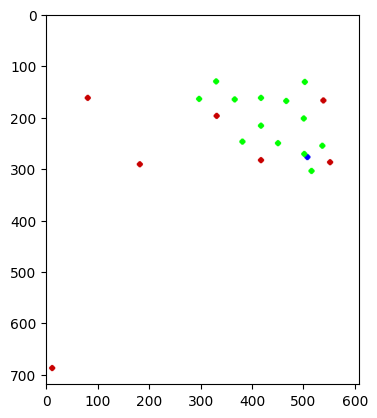

In [11]:
# method 1 - use local test class
env = BasicEnv13()
env.reset()
action_n = env.action_space.sample()
print('action_n',action_n)
action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
print(action)
state, reward, done, info = env.step(action)
print("Reward = {} with action = {}".format(reward,action))
#print(state)
import matplotlib.pyplot as plt
print(reward, done, info)
plt.figure()
plt.imshow(state)

In [12]:
state.shape

(719, 609, 3)

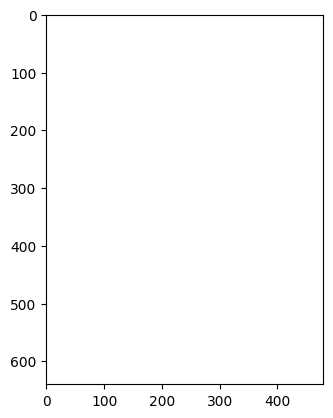

In [13]:
plt.figure()
whiteFrame = 255 * np.ones((640,480,3), np.uint8)
plt.imshow(whiteFrame)

In [17]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 4
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(4, 84, 84)

In [18]:
def process_observation_test(observation):
    if type(observation) == type(None):
        whiteFrame= 255 * np.ones((640,480,3), np.uint8)
        observation=whiteFrame
    # First convert the numpy array to a PIL Image
    img = Image.fromarray(observation)
    # Then resize the image
    img = img.resize(IMG_SHAPE)
    # And convert it to grayscale  (The L stands for luminance)
    #img = img.convert("L")
    # Convert the image back to a numpy array and finally return the image
    img = np.array(img)
    return img.astype('uint8')  # saves storage in experience memory

In [19]:
process_observation_test(None).shape

(84, 84, 3)

In [20]:
process_observation_test(state).shape

(84, 84, 3)

In [21]:
from PIL import Image  # To transform the image in the Processor
import numpy as np
import gym

# Convolutional Backbone Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam

# Keras-RL
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


In [22]:
nb_actions = env.action_space.n

In [23]:
nb_actions                            mmmmmm

20

In [26]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 3

In [27]:
class ImageProcessor(Processor):
    def process_observation(self,observation):
        if type(observation) == type(None):
            whiteFrame= 255 * np.ones((640,480,3), np.uint8)
            observation=whiteFrame
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        #img = img.convert("L")
        # Convert the image back to a numpy array and finally return the image
        img = np.array(img)
        return img.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):

        # We divide the observations by 255 to compress it into the intervall [0, 1].
        # This supports the training of the network
        # We perform this operation here to save memory.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


## Model Creation

**NOTE: Depending on your custom environment, this model will vary greatly, try reading papers that are solving similar problems to your own!**

In [28]:
input_shape = (IMG_SHAPE[0], IMG_SHAPE[1],3)
input_shape

(84, 84, 3)

In [29]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))

model.add(Convolution2D(32, (8, 8), strides=(4, 4),kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d. Consider increasing the input size. Received input shape [None, 84, 3, 84] which would produce output shape with a zero or negative value in a dimension.

In [188]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))  # (28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 82, 82, 64)        1792      
                                                                 
 conv2d_38 (Conv2D)          (None, 80, 80, 32)        18464     
                                                                 
 flatten_10 (Flatten)        (None, 204800)            0         
                                                                 
 dense_19 (Dense)            (None, 20)                4096020   
                                                                 
Total params: 4,116,276
Trainable params: 4,116,276
Non-trainable params: 0
_________________________________________________________________
None


----
## Creating the Agent

In [189]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

In [190]:
processor = ImageProcessor()

In [191]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [192]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
              train_interval=4, delta_clip=1)

In [193]:
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [194]:
weights_filename = 'test_dqn_worker_weights.h5f'
checkpoint_weights_filename = 'test_dqn_' + "worker" + '_weights_{step}.h5f'
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)

In [195]:
dqn.fit(env, nb_steps=1500000, callbacks=[checkpoint_callback], log_interval=100000, visualize=False)
# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

Training for 1500000 steps ...
worker_pos 0 0
The action is : (0, 0)
reward, done, info 0 True {}
Interval 1 (0 steps performed)


ValueError: Error when checking input: expected conv2d_37_input to have 4 dimensions, but got array with shape (1, 20, 84, 84, 3)